In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam, SGD
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import pickle

In [5]:
#data frame with the filtered topic labels and features that characterize each data entry:

file = open("tfidf_topics.pkl",'rb')
df = pickle.load(file)
file.close()


Text(0, 0.5, 'Number of topics')

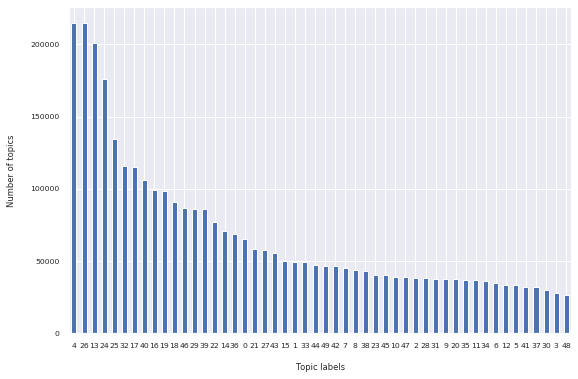

In [6]:
sns.set(font_scale=0.7)
df['text_tokens'].value_counts().plot(kind='bar', figsize=(9, 6), rot=0)
plt.xlabel("Topic labels", labelpad=14)
plt.ylabel("Number of topics", labelpad=14)
#plt.title("Histogram showing frequency of topics in the dataset", y=1.02);

In [7]:
#Tweet count for all the users considered
df['engaging_user_id'].value_counts()

72C2BE10D3673447A6D596E12C0523DA    502
3396F36ADFF2A01A34C0CB3486CABFEE    388
5049F4AC51D668D064214377EB38A8D3    320
3FC1A3B3B9C8D1BD6673C3B5B65A6E91    308
F1D8FA7C91B5EE653330E80D48C77AD1    297
                                   ... 
CA1ADC896703A58EDF577CC9BF6B7013     21
97938A219F10E85F1F7D940637380C81     21
8A77D34048D7DAA0FD289823FD79C6C9     21
AD54349064F929967A03AEA5CF0EEBBF     21
F41260F7A7C6D55C5712B5FE49EFE933     21
Name: engaging_user_id, Length: 107017, dtype: int64

In [8]:
#Convert date to yyyy-mm-dd hh:mm:ss format
import datetime
df['tweet_timestamp'] = df["tweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x)) 

In [9]:
t1 = df[(df["tweet_timestamp"] >= '2020-02-05 18:00:00') & (df["tweet_timestamp"] < '2020-02-06 06:00:00')]
t2 = df[(df["tweet_timestamp"] >= '2020-02-06 06:00:00') & (df["tweet_timestamp"] < '2020-02-06 18:00:00')]
t3 = df[(df["tweet_timestamp"] >= '2020-02-06 18:00:00') & (df["tweet_timestamp"] < '2020-02-07 06:00:00')]
t4 = df[(df["tweet_timestamp"] >= '2020-02-07 06:00:00') & (df["tweet_timestamp"] < '2020-02-07 18:00:00')]
t5 = df[(df["tweet_timestamp"] >= '2020-02-07 18:00:00') & (df["tweet_timestamp"] < '2020-02-08 06:00:00')]
t6 = df[(df["tweet_timestamp"] >= '2020-02-08 06:00:00') & (df["tweet_timestamp"] < '2020-02-08 18:00:00')]
t7 = df[(df["tweet_timestamp"] >= '2020-02-08 18:00:00') & (df["tweet_timestamp"] < '2020-02-09 06:00:00')]
t8 = df[(df["tweet_timestamp"] >= '2020-02-09 06:00:00') & (df["tweet_timestamp"] < '2020-02-09 18:00:00')]
t9 = df[(df["tweet_timestamp"] >= '2020-02-09 18:00:00') & (df["tweet_timestamp"] < '2020-02-10 06:00:00')]
t10 = df[(df["tweet_timestamp"] >= '2020-02-10 06:00:00') & (df["tweet_timestamp"] < '2020-02-10 18:00:00')]
t11 = df[(df["tweet_timestamp"] >= '2020-02-10 18:00:00') & (df["tweet_timestamp"] < '2020-02-11 06:00:00')]
t12 = df[(df["tweet_timestamp"] >= '2020-02-11 06:00:00') & (df["tweet_timestamp"] < '2020-02-11 18:00:00')]
t13 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
t14 = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]

# Each time period is 12 hrs
# Engagement frequency of user is from time periods t1 to t12 during training
# Recent history of user is considered from time periods t9 to t12 training 
# Current time period is considered as t13
# Testing will be carried out on time period t14


In [10]:


columns = ['reply_timestamp','tweet_timestamp', 'tweet_id',"retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]


In [11]:
#Recent history t9 to t12 for training

t9['retweet'] = np.where(pd.notnull(t9['retweet_timestamp']), 1, 0)
t9.drop(columns, axis=1,inplace=True)
t_9 = t9.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t9_history = t_9.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t9_history.fillna(0,inplace = True)
history_t9 = pd.DataFrame(t9_history.to_records())
for col in history_t9.columns:
  if col != 'engaging_user_id':
    history_t9.loc[history_t9[col] > 1, col] = 1

t10['retweet'] = np.where(pd.notnull(t10['retweet_timestamp']), 1, 0)
t10.drop(columns, axis=1,inplace=True)
t_10 = t10.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t10_history = t_10.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t10_history.fillna(0,inplace = True)
history_t10 = pd.DataFrame(t10_history.to_records())
for col in history_t10.columns:
  if col != 'engaging_user_id':
    history_t10.loc[history_t10[col] > 1, col] = 1

t11['retweet'] = np.where(pd.notnull(t11['retweet_timestamp']), 1, 0)
t11.drop(columns, axis=1,inplace=True)
t_11 = t11.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t11_history = t_11.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t11_history.fillna(0,inplace = True)
history_t11 = pd.DataFrame(t11_history.to_records())
for col in history_t11.columns:
  if col != 'engaging_user_id':
    history_t11.loc[history_t11[col] > 1, col] = 1


t12['retweet'] = np.where(pd.notnull(t12['retweet_timestamp']), 1, 0)
t12.drop(columns, axis=1,inplace=True)
t_12 = t12.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t12_history = t_12.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t12_history.fillna(0,inplace = True)
history_t12 = pd.DataFrame(t12_history.to_records())
for col in history_t12.columns:
  if col != 'engaging_user_id':
    history_t12.loc[history_t12[col] > 1, col] = 1

    
t13['retweet'] = np.where(pd.notnull(t13['retweet_timestamp']), 1, 0)
t13.drop(columns, axis=1,inplace=True)
t_13 = t13.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
t13_history = t_13.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
t13_history.fillna(0,inplace = True)
history_t13 = pd.DataFrame(t13_history.to_records())
for col in history_t13.columns:
  if col != 'engaging_user_id':
    history_t13.loc[history_t13[col] > 1, col] = 1


t14['retweet'] = np.where(pd.notnull(t14['retweet_timestamp']), 1, 0)
t14.drop(columns, axis=1,inplace=True)
t_14 = t14.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
test_info = t_14.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
test_info.fillna(0,inplace = True)
test = pd.DataFrame(test_info.to_records())
for col in test.columns:
  if col != 'engaging_user_id':
    test.loc[test[col] > 1, col] = 1    

In [12]:
#Engagement frequency for testing time
eng_frequency = df[df["tweet_timestamp"] < '2020-02-12 6:00:00']
eng_frequency['retweet'] = np.where(pd.notnull(eng_frequency['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency.drop(columns, axis=1,inplace=True)
engagement_history = eng_frequency.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history = engagement_history.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history.fillna(0,inplace = True)
history_frequency = pd.DataFrame(input_engagement_history.to_records())

In [13]:
#Engagement frequency for training time
eng_frequency_train = df[df["tweet_timestamp"] < '2020-02-11 18:00:00']
eng_frequency_train['retweet'] = np.where(pd.notnull(eng_frequency_train['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency_train.drop(columns, axis=1,inplace=True)
engagement_history_train = eng_frequency_train.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history_train = engagement_history_train.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history_train.fillna(0,inplace = True)
history_frequency_train = pd.DataFrame(input_engagement_history_train.to_records())

In [14]:

left_out_rows_t9 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t9['engaging_user_id'])]
for col in left_out_rows_t9.columns:
    if col != 'engaging_user_id':
        left_out_rows_t9[col].values[:] = 0
final_history_t9 = history_t9.append(left_out_rows_t9)
final_history_t9 = final_history_t9.sort_values('engaging_user_id')
final_history_t9.reset_index(drop=True, inplace=True)

left_out_rows_t10 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t10['engaging_user_id'])]
for col in left_out_rows_t10.columns:
    if col != 'engaging_user_id':
        left_out_rows_t10[col].values[:] = 0
final_history_t10 = history_t10.append(left_out_rows_t10)
final_history_t10 = final_history_t10.sort_values('engaging_user_id')
final_history_t10.reset_index(drop=True, inplace=True)

left_out_rows_t11 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t11['engaging_user_id'])]
for col in left_out_rows_t11.columns:
    if col != 'engaging_user_id':
        left_out_rows_t11[col].values[:] = 0
final_history_t11 = history_t11.append(left_out_rows_t11)
final_history_t11 = final_history_t11.sort_values('engaging_user_id')
final_history_t11.reset_index(drop=True, inplace=True)


left_out_rows_t12 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t12['engaging_user_id'])]
for col in left_out_rows_t12.columns:
    if col != 'engaging_user_id':
        left_out_rows_t12[col].values[:] = 0
final_history_t12 = history_t12.append(left_out_rows_t12)
final_history_t12 = final_history_t12.sort_values('engaging_user_id')
final_history_t12.reset_index(drop=True, inplace=True)


In [15]:

#label for training
left_out_rows_t13 = history_frequency[~history_frequency['engaging_user_id'].isin(history_t13['engaging_user_id'])]
for col in left_out_rows_t13.columns:
    if col != 'engaging_user_id':
        left_out_rows_t13[col].values[:] = 0
final_history_t13 = history_t13.append(left_out_rows_t13)
final_history_t13 = final_history_t13.sort_values('engaging_user_id')
final_history_t13.reset_index(drop=True, inplace=True)

#label for testing
left_out_rows = history_frequency[~history_frequency['engaging_user_id'].isin(test['engaging_user_id'])]
for col in left_out_rows.columns:
    if col != 'engaging_user_id':
        left_out_rows[col].values[:] = 0
final_test = test.append(left_out_rows)
final_test = final_test.sort_values('engaging_user_id')
final_test.reset_index(drop=True, inplace=True)        

In [16]:
#dataframes with engagement histories  
from functools import reduce
recent_history = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t9, final_history_t10, final_history_t11, final_history_t12])
recent_history_test = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history_t10, final_history_t11, final_history_t12, final_history_t13])

In [17]:
history_frequency = history_frequency.sort_values('engaging_user_id')
history_frequency_train = history_frequency_train.sort_values('engaging_user_id')

In [18]:
#topic recommendations generation for training and testing.

time = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]
left = time[time['retweet_timestamp'] >= 0]
time['retweet_timestamp'].fillna(0,inplace=True)

left['retweet_timestamp'] = left["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time = pd.concat([time,left]).drop_duplicates(keep=False)
time['retweet_timestamp'] = time['tweet_timestamp']
final = pd.concat([time,left])

final = final.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
final = final.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
final.drop(columns, axis=1,inplace=True)


time_1 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
left_1 = time_1[time_1['retweet_timestamp'] >= 0]
time_1['retweet_timestamp'].fillna(0,inplace=True)

left_1['retweet_timestamp'] = left_1["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
time_1 = pd.concat([time_1,left_1]).drop_duplicates(keep=False)
time_1['retweet_timestamp'] = time_1['tweet_timestamp']
initial = pd.concat([time_1,left_1])

initial = initial.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
initial = initial.reset_index(drop=True)

columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
initial.drop(columns, axis=1,inplace=True)

In [19]:
# We consider the positive examples for topic recommendations from all the tweets posted during the active states and vice versa. 
# An active state is defined as a period between when a tweet is published and engaged


#Function action_recommend for determining the active states
def active_recommend(x):
    g = 3
    for index, row in x.iterrows():
      if g != 10 :
        a = row['engaging_user_id']
        b = row['tweet_timestamp']
        c = row['retweet_timestamp']
        p = 0
        if b != c :
          g = 10
      if (row['tweet_timestamp'] != row['retweet_timestamp']):
          p = 1
          d = row['engaging_user_id']
          e = row['tweet_timestamp']
          f = row['retweet_timestamp']
      elif row['tweet_timestamp'] == row['retweet_timestamp']:
          if row['engaging_user_id'] == a:
            p = 0
          elif row['engaging_user_id'] == d:
            if (row['tweet_timestamp'] >= e) & (row['tweet_timestamp'] <= f):
              p = 1
            else:
              p = 0
      x.loc[index,'recommend'] = p
    return final
final = active_recommend(final)    # Test Recommendations 
inital = active_recommend(initial) # Training Recommendations

In [20]:
final['recommend'].value_counts()

1.0    287758
0.0    105948
Name: recommend, dtype: int64

In [21]:
initial['recommend'].value_counts()

1.0    221141
0.0     71676
Name: recommend, dtype: int64

In [22]:
column = ['tweet_timestamp','retweet_timestamp']
final.drop(column, axis=1,inplace=True)
initial.drop(column, axis=1,inplace=True)

In [23]:

final_1 = final.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
final_2 = final_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
final_2.fillna(0,inplace = True)
final_3 = pd.DataFrame(final_2.to_records())

for col in final_3.columns:
  if col != 'engaging_user_id':
    final_3.loc[final_3[col] > 1, col] = 1
    
    
left_out_rows_f = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_f.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
final_4 = final_3.append(left_out_rows_f)
recommend_test = final_4.sort_values('engaging_user_id')
recommend_test.reset_index(drop=True, inplace=True)  #Dataframe with topic recommendation during testing

In [24]:
initial_1 = initial.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
initial_2 = initial_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
initial_2.fillna(0,inplace = True)
initial_3 = pd.DataFrame(final_2.to_records())

for col in initial_3.columns:
  if col != 'engaging_user_id':
    initial_3.loc[final_3[col] > 1, col] = 1
    
left_out_rows_g = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
for col in left_out_rows_g.columns:
    if col != 'engaging_user_id':
        left_out_rows_f[col].values[:] = 0
initial_4 = initial_3.append(left_out_rows_f)
recommend = initial_4.sort_values('engaging_user_id')
recommend.reset_index(drop=True, inplace=True)      #Dataframe with topic recommendation during training
    

In [25]:
X_recent_2 = recent_history.drop('engaging_user_id', axis=1).values
X_recent_1 = X_recent_2.reshape(-1,50,4)

X_recent_2_test = recent_history_test.drop('engaging_user_id', axis=1).values
X_recent_1_test = X_recent_2_test.reshape(-1,50,4)



X_freq_1 = history_frequency.drop('engaging_user_id', axis=1).values
X_freq_1_train = history_frequency_train.drop('engaging_user_id', axis=1).values


X_recommend_1 = recommend.drop('engaging_user_id', axis=1).values
X_recommend_t = recommend_test.drop('engaging_user_id', axis=1).values

y_1 = final_history_t13.drop('engaging_user_id', axis=1).values

y_t = final_test.drop('engaging_user_id', axis=1).values

#INPUTS



In [110]:
X_recent = torch.FloatTensor(X_recent_1)              #Recent Engagement History tensor input for training
X_freq = torch.FloatTensor(X_freq_1_train)            #Engagement Frequency tensor input for training
X_recommend = torch.FloatTensor(X_recommend_1)        #Topic Recommendation tensor input for training
y = torch.FloatTensor(y_1)                            #Engagement output tensor input for training


X_recent_test = torch.FloatTensor(X_recent_1_test)    #Recent Engagement History tensor input for testing
X_freq_test = torch.FloatTensor(X_freq_1)             #Engagement Frequency tensor input for testing
X_recommend_test = torch.FloatTensor(X_recommend_t)   #Topic Recommendation tensor input for testing
Y_test = torch.FloatTensor(y_t)                       #Engagement output tensor input for training

In [111]:
X_freq = F.normalize(X_freq, p=2, dim=1)              #Normalized Engagement Frequency tensor input for training
X_freq_test = F.normalize(X_freq_test, p=2, dim=1)    #Normalized Engagement Frequency tensor input for testing

In [112]:
final_test['1'].value_counts()
b = []
for i in range(50):
      b.append(final_history_t13[str(i)].sum())
np.array(b)
c = 107017*np.ones((50))
weights  = torch.tensor((c-np.array(b))/np.array(b))

In [113]:
filters = 20
L = 10
class DNN_f(nn.Module):
    def __init__(self):
        super().__init__()
        #frequency input
        self.fc1 = nn.Linear(in_features=50, out_features=L)

        #history input 32 * 50 * 4
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
        self.leaky = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
        self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


        #recommend input
        self.fc3 = nn.Linear(in_features=50, out_features=L)
        
        #final linear
        self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
        self.fc4 = nn.Linear(in_features=45, out_features=1)

 
    def forward(self, x, y, z, a):
        x1 = self.fc1(x)      ### EH
        x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
        y_ = y.view(-1,1,50,4)
        y1 = self.conv1(y_)
        y1 = self.leaky(y1)
        y2 = y1.view(-1,50,filters)   ####   ET       
        y1 = self.conv2(y1)
        y1 = self.conv3(y1)
        y3 = y1.view(-1,50,filters)   ####   ETBAR
        
        z1 = self.fc3(z)    ####  DT
        z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
        w = torch.stack((x, x2,z, z2), dim=2)
        v = torch.cat((y2,y3),dim =2)
        u = torch.cat((w,v),dim=2)
        a = a.view(-1,50,1)
        r = torch.cat((a,u),dim = 2)
        
        r = r.view(-1,1,50,5+2*(filters))
        t = self.conv4(r)
        s = t.view(-1,50)
        
        #r = r.view(-1,50,5+2*(filters))
        #t = self.fc4(r)
        #s = t.view(-1,50)

        return s

In [115]:
# filters = 20
# L = 10
# class DNN_l(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #frequency input
#         self.fc1 = nn.Linear(in_features=50, out_features=L)

#         #history input 32 * 50 * 4
#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
#         self.leaky = nn.LeakyReLU()
#         self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
#         self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


#         #recommend input
#         self.fc3 = nn.Linear(in_features=50, out_features=L)
        
#         #final linear
#         self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
#         self.fc4 = nn.Linear(in_features=49, out_features=500)
        
#         self.fc5 = nn.Linear(in_features=500, out_features=100)
        
#         self.fc6 = nn.Linear(in_features=100, out_features=1)
        
        

 
#     def forward(self, x, y, z, a):
#         x1 = self.fc1(x)      ### EH
#         x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
#         y_ = y.view(-1,1,50,4)
#         y1 = self.conv1(y_)
#         y1 = self.leaky(y1)
#         y2 = y1.view(-1,50,filters)   ####   ET       
#         y1 = self.conv2(y1)
#         y1 = self.conv3(y1)
#         y3 = y1.view(-1,50,filters)   ####   ETBAR
        
#         z1 = self.fc3(z)    ####  DT
#         z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
#         w = torch.stack((x, x2,z, z2), dim=2)
#         v = torch.cat((y2,y3),dim =2)
#         u = torch.cat((w,v),dim=2)
#         a = a.view(-1,50,1)
#         r = torch.cat((a,u),dim = 2)
        
#         #r = r.view(-1,50,5+2*(filters))
#         #r = torch.cat((r,y),dim=2)
#         #r = r.view(-1,1,50,5+2*(filters))
#         #t = self.conv4(r)
#         #s = t.view(-1,50)
        
        
#         r = r.view(-1,50,5+2*(filters))
#         r = torch.cat((r,y),dim=2)
#         t = self.fc4(r)
#         t = self.fc5(t)
#         t = self.fc6(t)
#         s = t.view(-1,50)

#         return s

In [116]:
torch.ones([32, 50], dtype=torch.float64).shape

torch.Size([32, 50])

In [117]:
model = DNN_f()
model = model.to(device)

In [118]:
optimizer = Adam(model.parameters(), lr=1e-5)
#loss_func = nn.BCEWithLogitsLoss(pos_weight = weights, reduction = 'sum').cuda()
loss_func = nn.BCEWithLogitsLoss().cuda()

BATCH_SIZE = 32
train_loss = 0
losses = []
steps = []
step = 0
count = 0
EPOCHS = 50

In [119]:
X_indicator = torch.ones([107017, 50])
import time
start_time = time.time()
train_dataset = TensorDataset(X_freq, X_recent, X_recommend, y, X_indicator)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
print ("--- %s seconds ---" % (time.time() - start_time))


for epoch_num in range(EPOCHS):
    model.train()
    for step_num, batch_data in enumerate(train_dataloader):
        freq, recent, recommend, labels, indicator = tuple(t.to(device)for t in batch_data)
        probas = model(freq, recent, recommend, indicator)
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()

        model.zero_grad()
        batch_loss.backward()


        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(y)/BATCH_SIZE, train_loss / (count + 1)))
        print ("--- %s seconds ---" % (time.time() - start_time))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1
        count += 1


Epoch:  50
3344/3344.28125 loss: 0.0428614956144444 
--- 801.4946603775024 seconds ---


In [35]:


torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

model = describe_model()
checkpoint = torch.load('checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

In [120]:
model.eval()

with torch.no_grad():

    logits_train = model(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
    logits_test = model(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
    numpy_logits_train = logits_train.detach().numpy()
    numpy_logits_test = logits_test.detach().numpy()
    
        

In [121]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)


In [122]:
#Converting logits to probabilities
numpy_probas_test = sigmoid_v(numpy_logits_test)
numpy_probas_train = sigmoid_v(numpy_logits_train)

In [123]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),numpy_probas_test)

1.799102066568455

In [124]:
#Performance Metrics          
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result





Best Threshold=0.006943, G-Mean=0.770


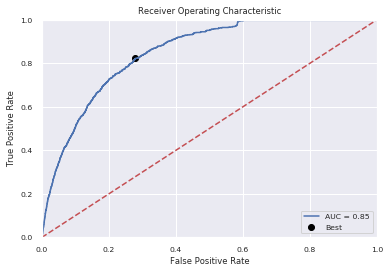

Best Threshold=0.004930, G-Mean=0.772


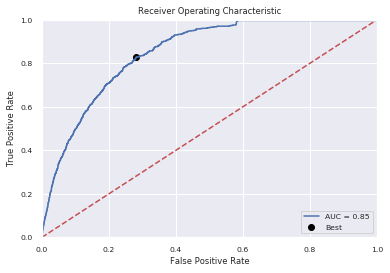

Best Threshold=0.006080, G-Mean=0.792


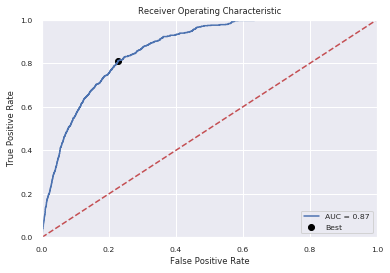

Best Threshold=0.003082, G-Mean=0.777


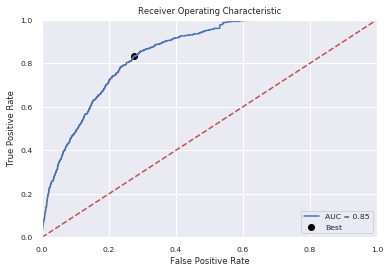

Best Threshold=0.016185, G-Mean=0.754


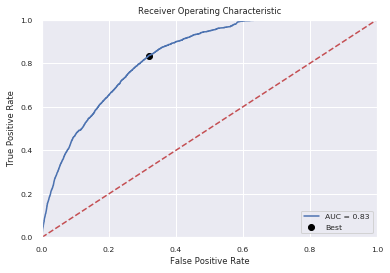

Best Threshold=0.003562, G-Mean=0.784


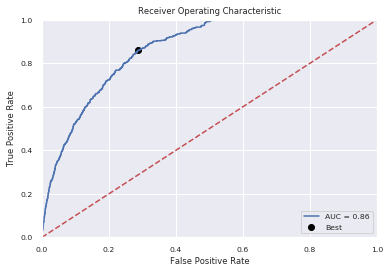

Best Threshold=0.006208, G-Mean=0.802


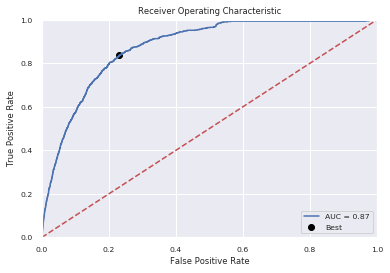

Best Threshold=0.004309, G-Mean=0.762


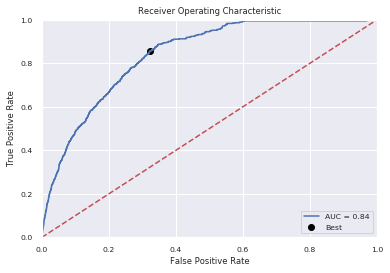

Best Threshold=0.002606, G-Mean=0.773


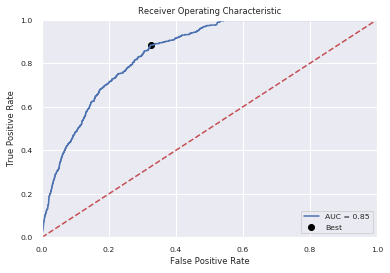

Best Threshold=0.005063, G-Mean=0.786


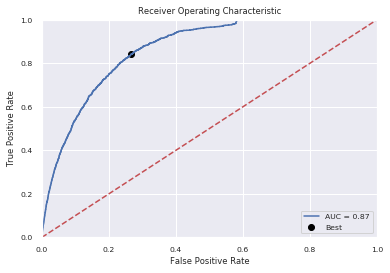

Best Threshold=0.005226, G-Mean=0.784


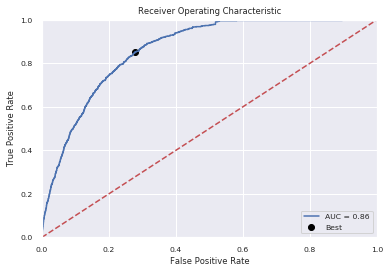

Best Threshold=0.004028, G-Mean=0.771


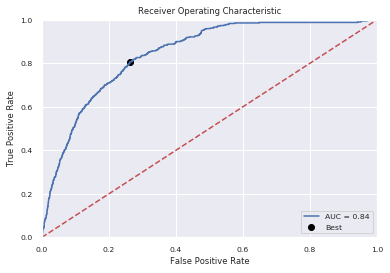

Best Threshold=0.003974, G-Mean=0.764


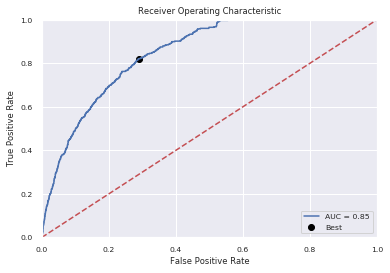

Best Threshold=0.032115, G-Mean=0.863


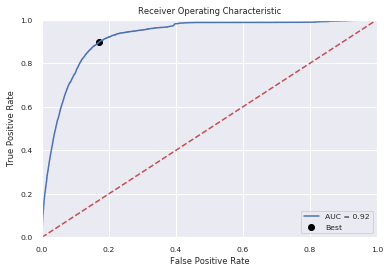

Best Threshold=0.005600, G-Mean=0.759


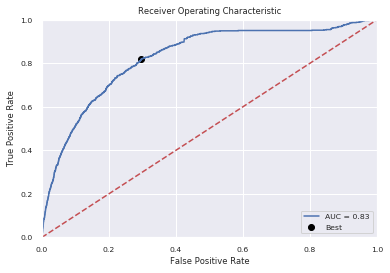

Best Threshold=0.005480, G-Mean=0.806


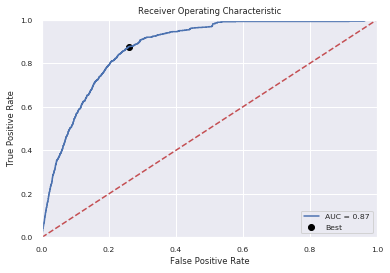

Best Threshold=0.008934, G-Mean=0.769


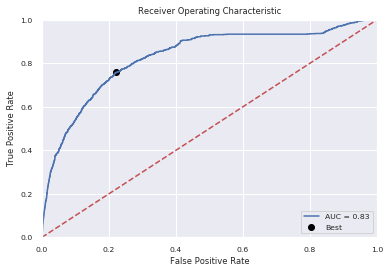

Best Threshold=0.017390, G-Mean=0.838


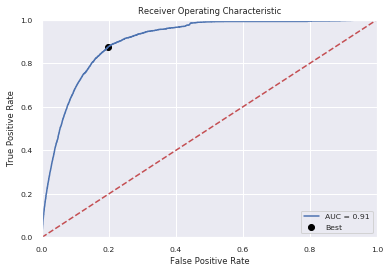

Best Threshold=0.011525, G-Mean=0.806


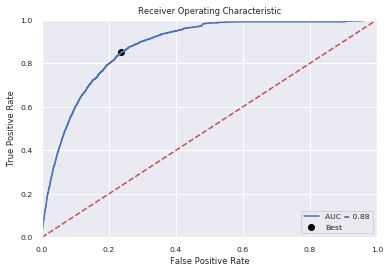

Best Threshold=0.010782, G-Mean=0.760


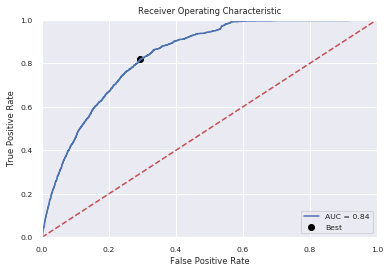

Best Threshold=0.004103, G-Mean=0.763


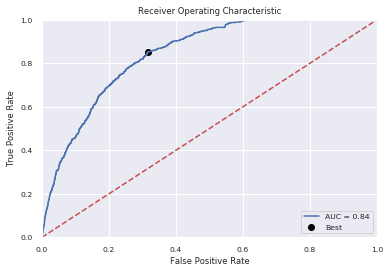

Best Threshold=0.005844, G-Mean=0.759


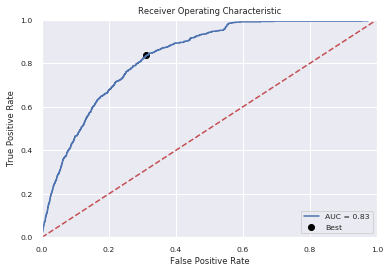

Best Threshold=0.010544, G-Mean=0.789


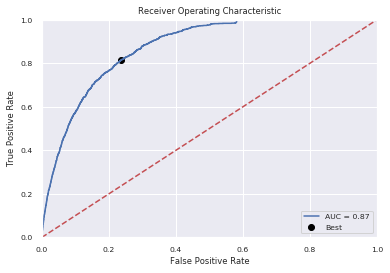

Best Threshold=0.003374, G-Mean=0.765


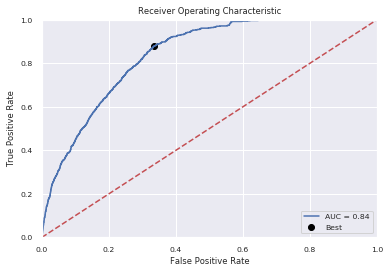

Best Threshold=0.021135, G-Mean=0.858


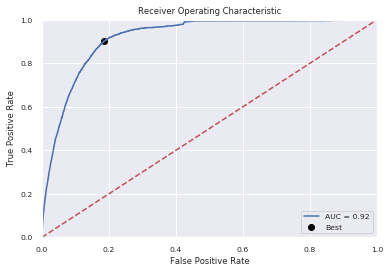

Best Threshold=0.004509, G-Mean=0.762


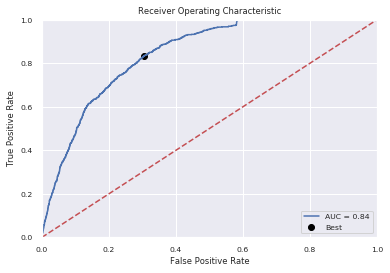

Best Threshold=0.016032, G-Mean=0.748


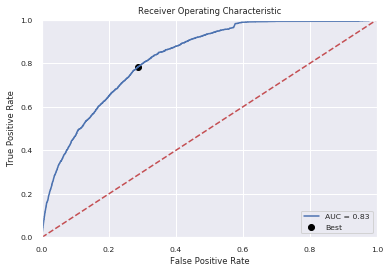

Best Threshold=0.006473, G-Mean=0.797


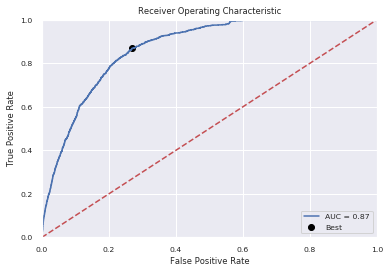

Best Threshold=0.006389, G-Mean=0.804


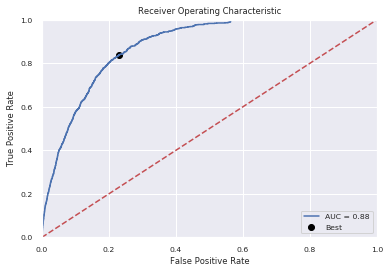

Best Threshold=0.009840, G-Mean=0.854


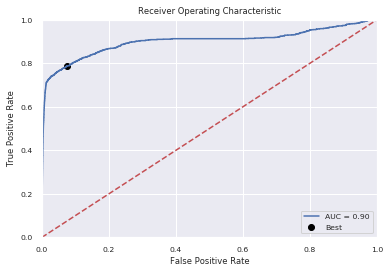

Best Threshold=0.003119, G-Mean=0.759


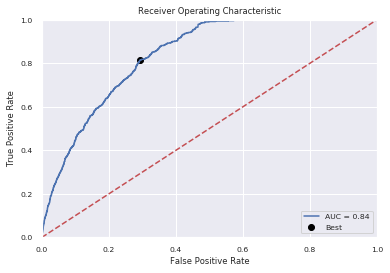

Best Threshold=0.004966, G-Mean=0.771


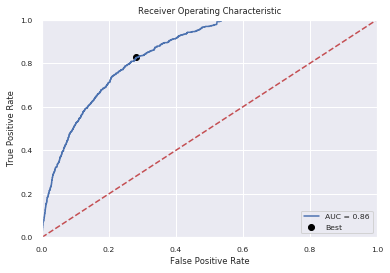

Best Threshold=0.009631, G-Mean=0.832


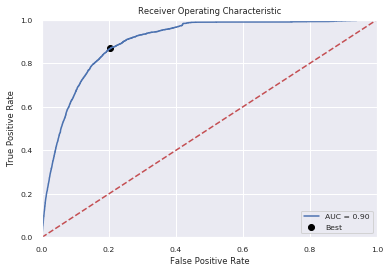

Best Threshold=0.008368, G-Mean=0.810


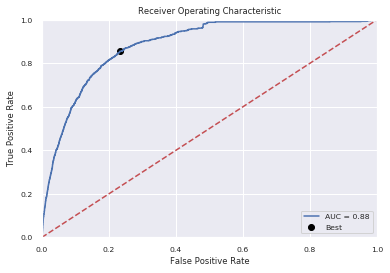

Best Threshold=0.003564, G-Mean=0.766


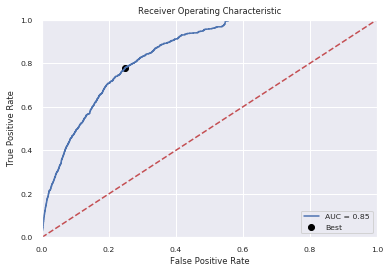

Best Threshold=0.004287, G-Mean=0.779


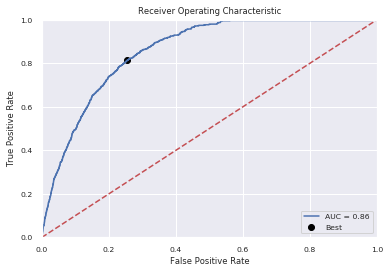

Best Threshold=0.006642, G-Mean=0.818


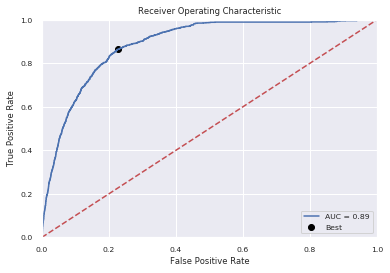

Best Threshold=0.002884, G-Mean=0.747


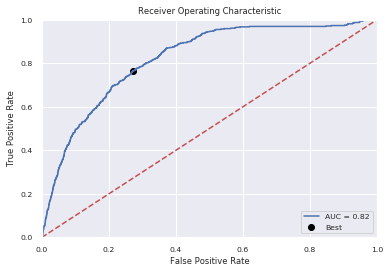

Best Threshold=0.004148, G-Mean=0.773


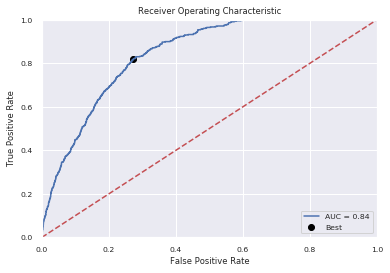

Best Threshold=0.008558, G-Mean=0.785


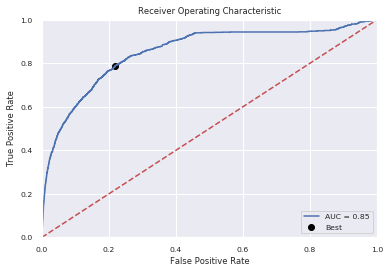

Best Threshold=0.009239, G-Mean=0.758


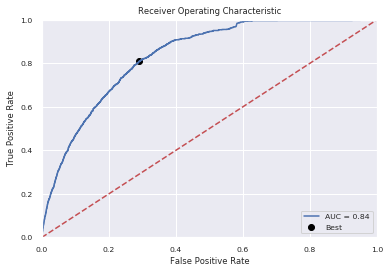

Best Threshold=0.003194, G-Mean=0.770


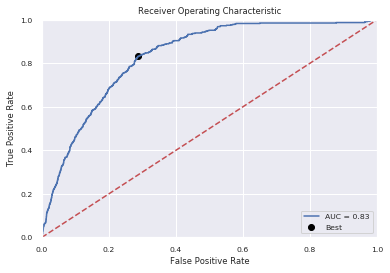

Best Threshold=0.004945, G-Mean=0.777


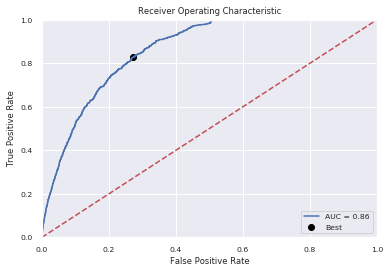

Best Threshold=0.007837, G-Mean=0.797


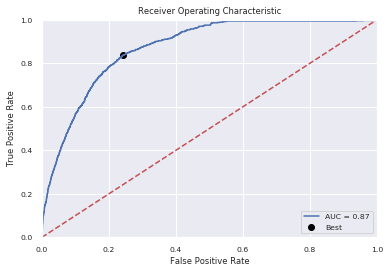

Best Threshold=0.007124, G-Mean=0.791


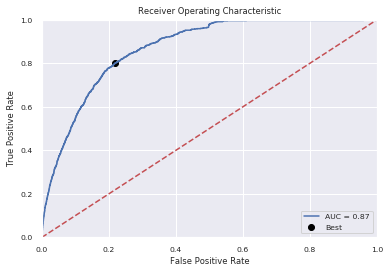

Best Threshold=0.007047, G-Mean=0.767


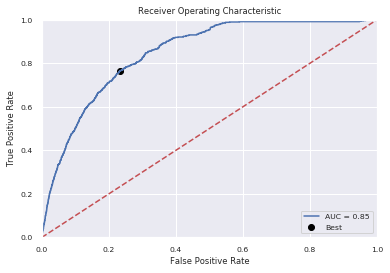

Best Threshold=0.006196, G-Mean=0.792


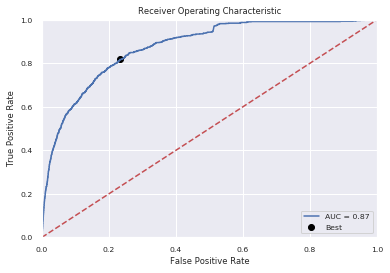

Best Threshold=0.005606, G-Mean=0.777


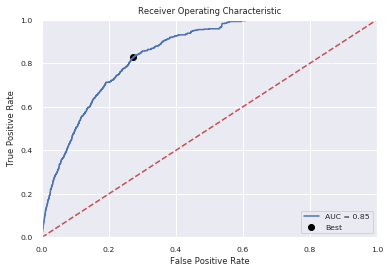

Best Threshold=0.003477, G-Mean=0.794


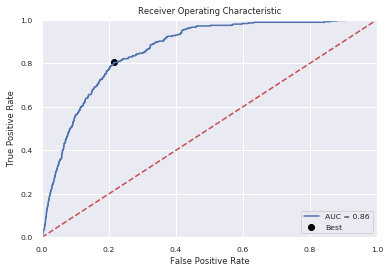

Best Threshold=0.005345, G-Mean=0.794


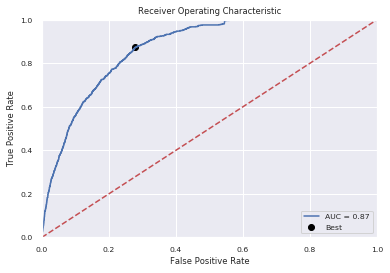

In [125]:
thresh = []
roc = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), numpy_probas_test[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    roc.append(roc_auc)
    thresh.append(optimal_threshold)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [126]:
sum(roc)/50

0.8593835804290488

In [43]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

for i in range(50):
    numpy_probas_test[:,i] = to_labels(numpy_probas_test[:,i],thresh[i])

In [44]:
scores = []
for i in range(50):
    scores.append(binary_classification_performance(Y_test[:,i].numpy(),numpy_probas_test[:,i]))

In [45]:
f = pd.concat(scores)

In [46]:
f.mean(axis=0)

Accuracy                          0.7320
Precision (or PPV)                0.0374
Recall (senitivity or TPR)        0.8488
f1 score                          0.0688
Specificty (or TNR)               0.0374
NPV                               0.8488
True Positive                 77368.6600
True Negative                   992.6000
False Positive                28494.6200
False Negative                  161.1200
dtype: float64

In [47]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), numpy_probas_test)

array([[[ 77705,  28399],
        [   162,    751]],

       [[ 73089,  33206],
        [   100,    622]],

       [[ 80259,  25939],
        [   141,    678]],

       [[ 76516,  30066],
        [    72,    363]],

       [[ 69061,  35409],
        [   373,   2174]],

       [[ 74290,  32217],
        [    53,    457]],

       [[ 81190,  24866],
        [   145,    816]],

       [[ 76198,  30211],
        [   106,    502]],

       [[ 70779,  35781],
        [    53,    404]],

       [[ 78961,  26669],
        [   188,   1199]],

       [[ 77628,  28621],
        [   112,    656]],

       [[ 76916,  29680],
        [    68,    353]],

       [[ 79436,  27172],
        [    80,    329]],

       [[ 82751,  16948],
        [   784,   6534]],

       [[ 80114,  26188],
        [   164,    551]],

       [[ 77603,  28585],
        [    91,    738]],

       [[ 79952,  26124],
        [   184,    757]],

       [[ 81438,  22232],
        [   360,   2987]],

       [[ 76983,  28269],
  

# Binary Logits

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [49]:
#Converting engagement frequencies from tensor to numpy array

X_freq_1 = X_freq.numpy()
X_freq_1_test = X_freq_test.numpy()


In [50]:
empty_train_p = []
empty_test_p = []
for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]     #Engagement history by topic as input for training
    freq_lm_train = X_freq_1[:,i]                            #Engagement frequncy by topic as input for training
    recommend_lm_train = X_recommend_1[:,i]                  #Recommendations by topic as input for training
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]] #Engagement history by topic as input for testing
    freq_lm_test = X_freq_1_test[:,i]                        #Engagement frequncy by topic as input for testing
    recommend_lm_test = X_recommend_t[:,i]                   #Recommendations by topic as input for testing


    y_lm_train = y_1[:,i]                                    #Engagement labels

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])  #Concatenated input features for training

    #LR = LogisticRegression(class_weight="balanced")
    LR = LogisticRegression()

    LR.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test]) #Concatenated input features for testing
    
    empty_train_p.append((LR.predict_proba(X)[:,1]))
       
    empty_test_p.append((LR.predict_proba(X_test)[:,1]))
      

In [51]:
prediction_lr_train_p = np.transpose(np.array(empty_train_p))  #Predictions for training data
prediction_lr_test_p = np.transpose(np.array(empty_test_p))    #Predictions for test data

In [52]:
from sklearn.metrics import log_loss
log_loss(y_t,prediction_lr_test_p)

1.8135723806680297

Best Threshold=0.008881, G-Mean=0.966


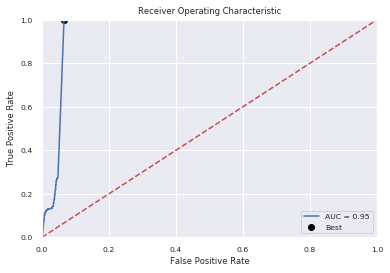

Best Threshold=0.006259, G-Mean=0.973


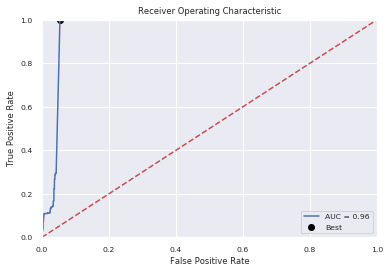

Best Threshold=0.007166, G-Mean=0.973


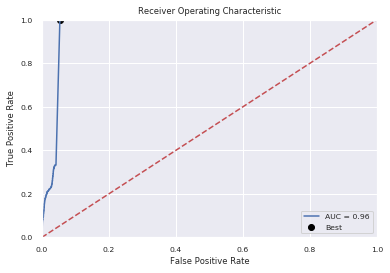

Best Threshold=0.003187, G-Mean=0.977


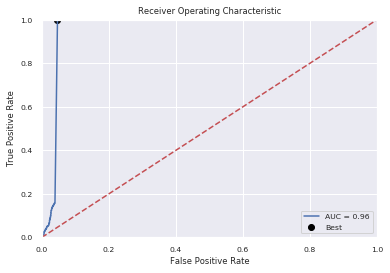

Best Threshold=0.016084, G-Mean=0.877


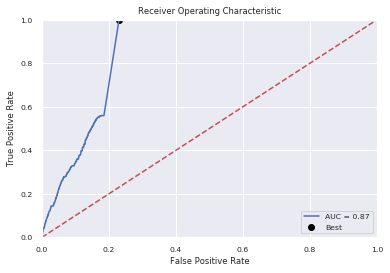

Best Threshold=0.004598, G-Mean=0.975


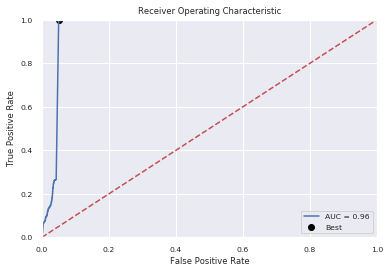

Best Threshold=0.008960, G-Mean=0.979


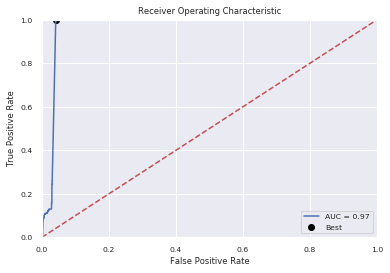

Best Threshold=0.006010, G-Mean=0.979


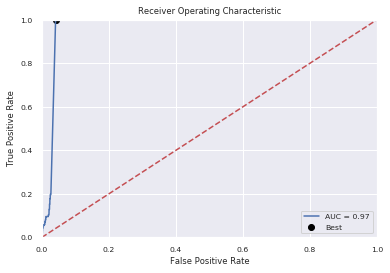

Best Threshold=0.003978, G-Mean=0.973


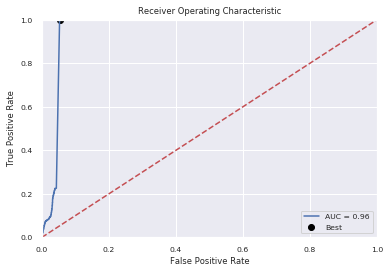

Best Threshold=0.006785, G-Mean=0.973


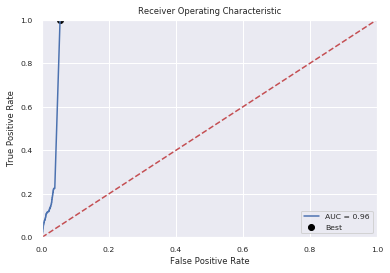

Best Threshold=0.006264, G-Mean=0.965


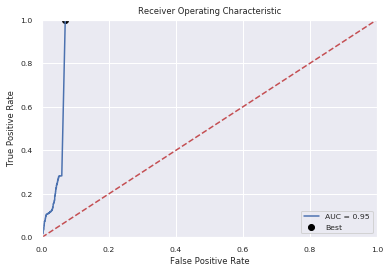

Best Threshold=0.004572, G-Mean=0.975


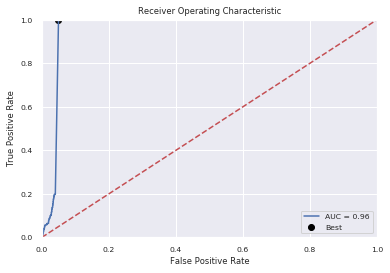

Best Threshold=0.005817, G-Mean=0.981


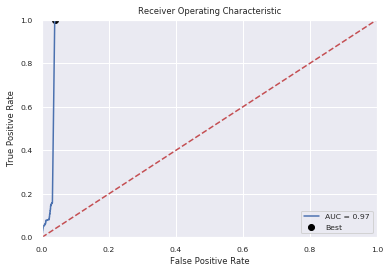

Best Threshold=0.024027, G-Mean=0.890


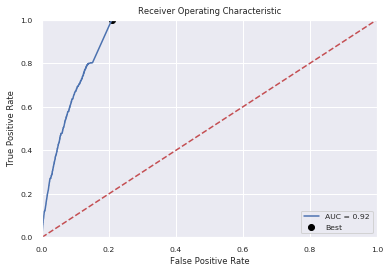

Best Threshold=0.007566, G-Mean=0.964


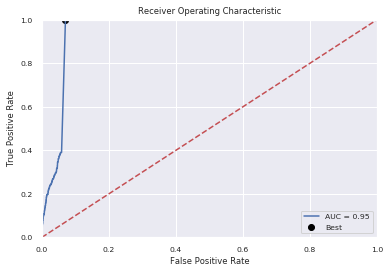

Best Threshold=0.005521, G-Mean=0.954


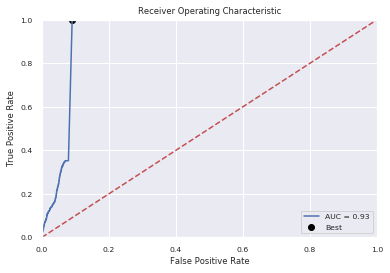

Best Threshold=0.006540, G-Mean=0.945


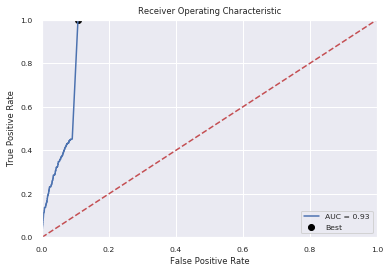

Best Threshold=0.015913, G-Mean=0.912


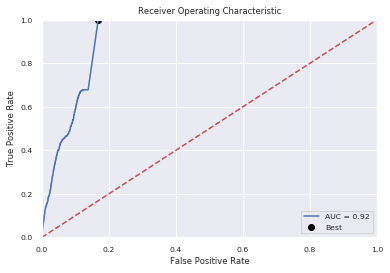

Best Threshold=0.011180, G-Mean=0.934


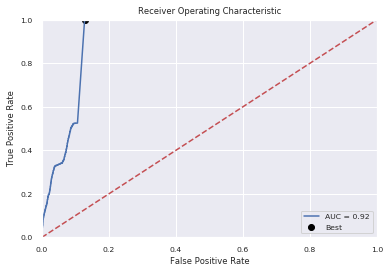

Best Threshold=0.012391, G-Mean=0.936


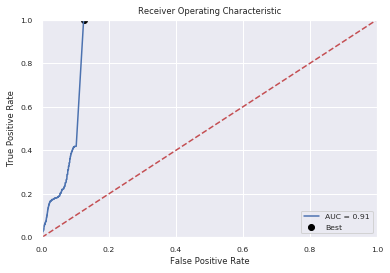

Best Threshold=0.005452, G-Mean=0.974


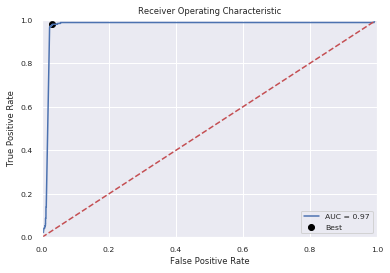

Best Threshold=0.008711, G-Mean=0.974


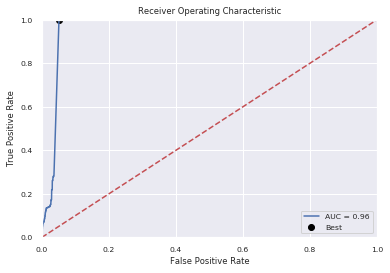

Best Threshold=0.010566, G-Mean=0.946


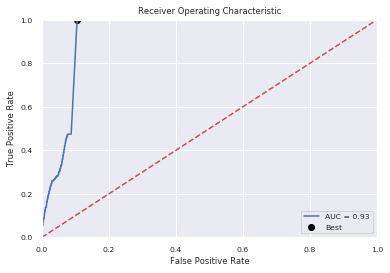

Best Threshold=0.005802, G-Mean=0.978


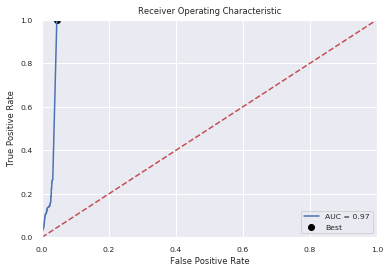

Best Threshold=0.012802, G-Mean=0.896


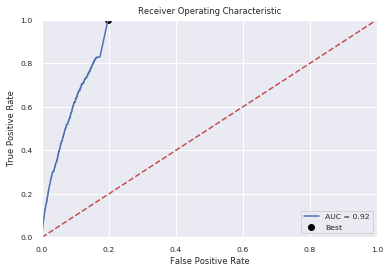

Best Threshold=0.004758, G-Mean=0.942


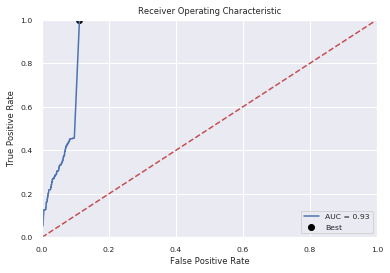

Best Threshold=0.015143, G-Mean=0.882


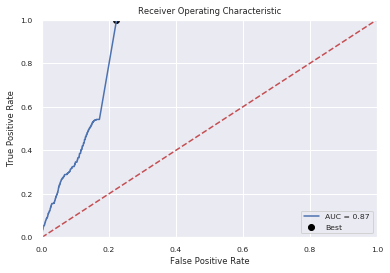

Best Threshold=0.008100, G-Mean=0.962


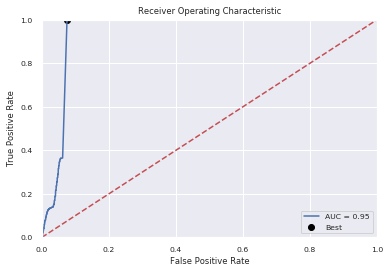

Best Threshold=0.006562, G-Mean=0.969


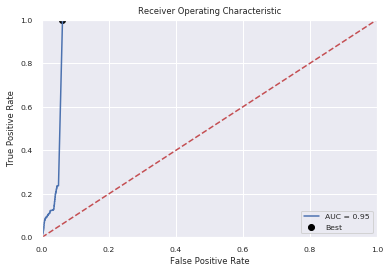

Best Threshold=0.002831, G-Mean=0.969


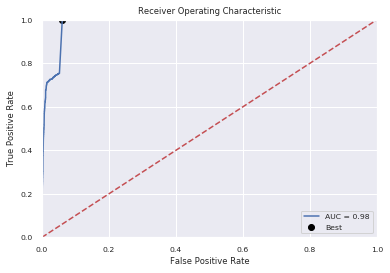

Best Threshold=0.003794, G-Mean=0.975


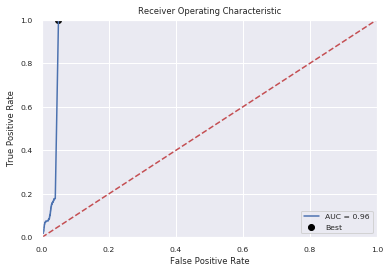

Best Threshold=0.006649, G-Mean=0.980


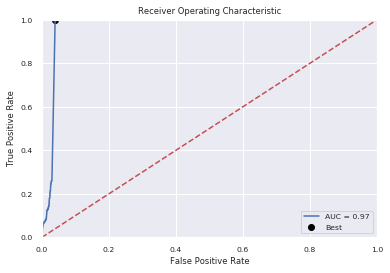

Best Threshold=0.009130, G-Mean=0.917


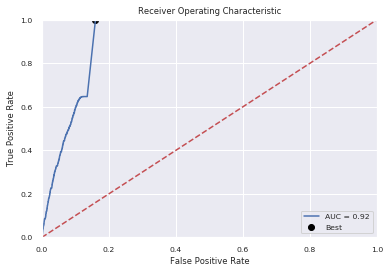

Best Threshold=0.011429, G-Mean=0.968


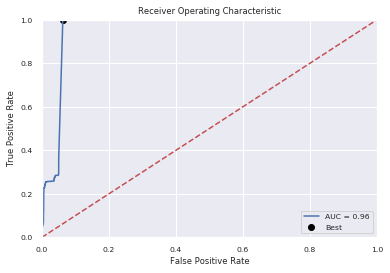

Best Threshold=0.004108, G-Mean=0.975


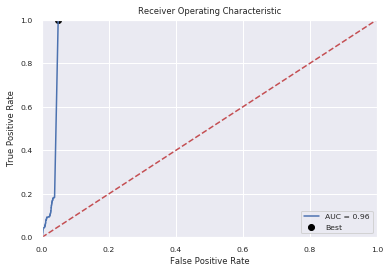

Best Threshold=0.005948, G-Mean=0.981


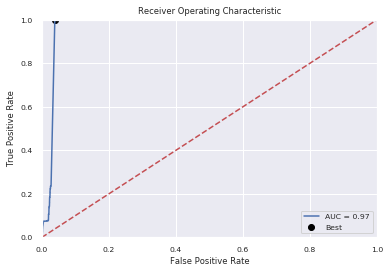

Best Threshold=0.007821, G-Mean=0.954


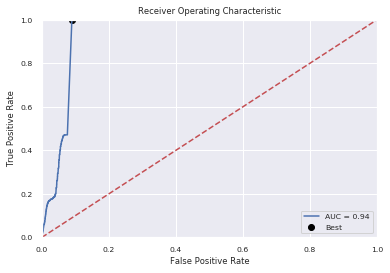

Best Threshold=0.003965, G-Mean=0.983


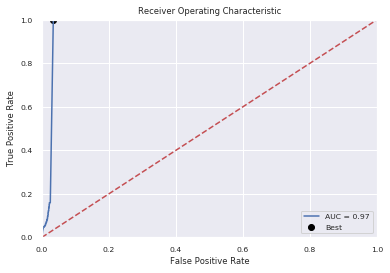

Best Threshold=0.005493, G-Mean=0.978


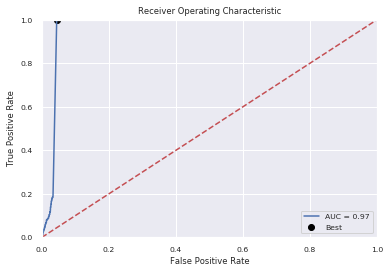

Best Threshold=0.005798, G-Mean=0.949


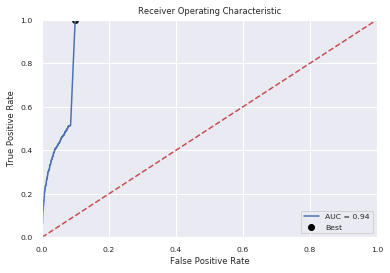

Best Threshold=0.011456, G-Mean=0.952


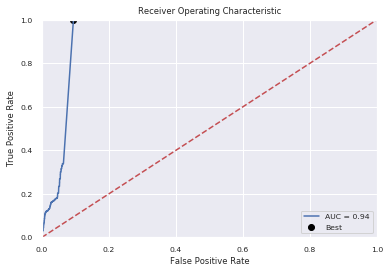

Best Threshold=0.004750, G-Mean=0.984


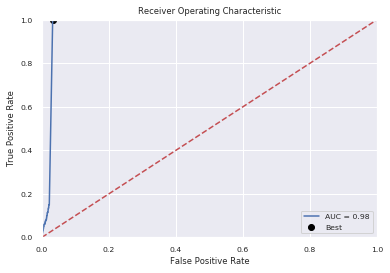

Best Threshold=0.006533, G-Mean=0.975


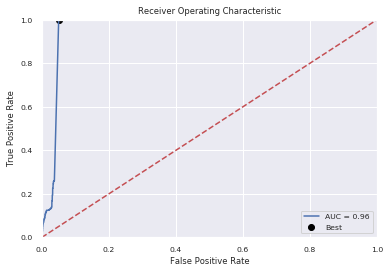

Best Threshold=0.009771, G-Mean=0.961


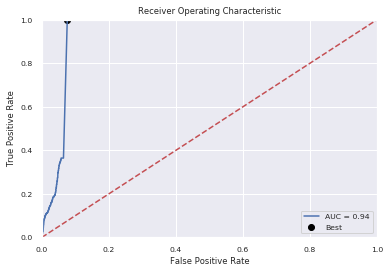

Best Threshold=0.007426, G-Mean=0.969


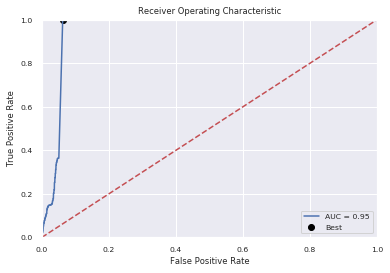

Best Threshold=0.007805, G-Mean=0.972


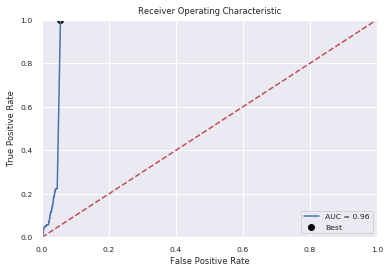

Best Threshold=0.004889, G-Mean=0.958


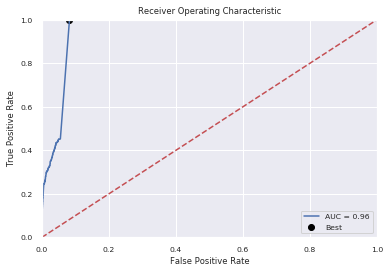

Best Threshold=0.008410, G-Mean=0.986


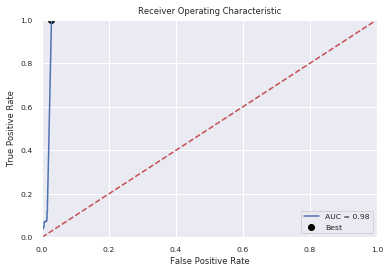

Best Threshold=0.005163, G-Mean=0.988


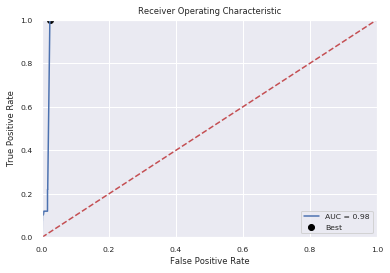

Best Threshold=0.006478, G-Mean=0.966


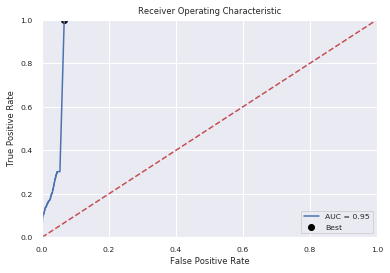

In [53]:
thresh_lr = []
roc_lr = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lr_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    thresh_lr.append(optimal_threshold)
    roc_lr.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [54]:
sum(roc_lr)/50  #Average AUC-ROC score 

0.9497445073771786

In [55]:
for i in range(50):
    prediction_lr_test_p[:,i] = to_labels(prediction_lr_test_p[:,i],thresh_lr[i])

In [56]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), prediction_lr_test_p)


array([[[ 99114,   6990],
        [     0,    913]],

       [[100608,   5687],
        [     0,    722]],

       [[100512,   5686],
        [     0,    819]],

       [[101669,   4913],
        [     0,    435]],

       [[ 80422,  24048],
        [     0,   2547]],

       [[101221,   5286],
        [     0,    510]],

       [[101687,   4369],
        [     0,    961]],

       [[102071,   4338],
        [     0,    608]],

       [[100946,   5614],
        [     0,    457]],

       [[ 99920,   5710],
        [     0,   1387]],

       [[ 98881,   7368],
        [     0,    768]],

       [[101354,   5242],
        [     0,    421]],

       [[102547,   4061],
        [     0,    409]],

       [[ 78935,  20764],
        [     0,   7318]],

       [[ 98851,   7451],
        [     0,    715]],

       [[ 96638,   9550],
        [     0,    829]],

       [[ 94694,  11382],
        [     0,    941]],

       [[ 86276,  17394],
        [     0,   3347]],

       [[ 91868,  13384],
  

In [57]:
scores_lr = []
for i in range(50):
    scores_lr.append(binary_classification_performance(Y_test[:,i].numpy(),prediction_lr_test_p[:,i]))

In [58]:
f_lr = pd.concat(scores_lr)

In [59]:
f_lr.mean(axis=0)

Accuracy                          0.9230
Precision (or PPV)                0.1172
Recall (senitivity or TPR)        0.9996
f1 score                          0.2086
Specificty (or TNR)               0.1172
NPV                               0.9996
True Positive                 97588.9400
True Negative                  1153.5200
False Positive                 8274.3400
False Negative                    0.2000
dtype: float64

# Light GBM model

In [60]:
!pip install lightgbm

In [61]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [62]:
empty_train_1p = []
empty_test_1p = []


for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]
    freq_lm_train = X_freq_1[:,i]
    recommend_lm_train = X_recommend_1[:,i]
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]]
    freq_lm_test = X_freq_1_test[:,i]
    recommend_lm_test = X_recommend_t[:,i]


    y_lm_train = y_1[:,i]
    

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])

    LGBM = LGBMClassifier()

    LGBM.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test])
    
    empty_train_1p.append((LGBM.predict_proba(X)[:,0]))

    empty_test_1p.append((LGBM.predict_proba(X_test)[:,0]))
        


In [63]:
prediction_lgbm_train_p = np.transpose(np.array(empty_train_1p))
prediction_lgbm_test_p = np.transpose(np.array(empty_test_1p))

In [64]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),prediction_lgbm_test_p)

2.141855793091419

0.9947524686680419
Best Threshold=0.994752, G-Mean=0.889


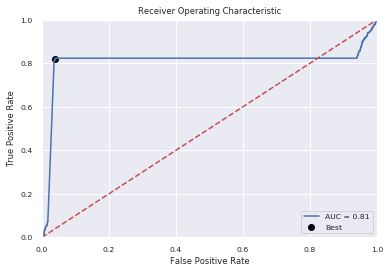

0.9965420734262784
Best Threshold=0.996542, G-Mean=0.905


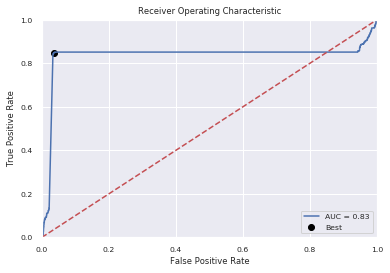

0.9962496950171744
Best Threshold=0.995222, G-Mean=0.188


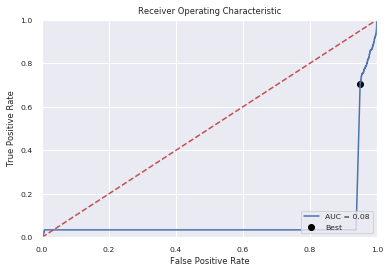

0.9976553628259752
Best Threshold=0.997655, G-Mean=0.977


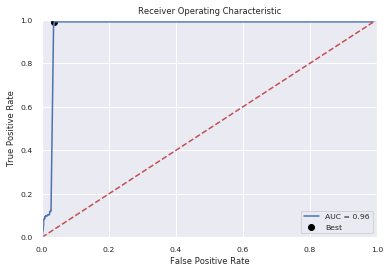

0.9911751173019995
Best Threshold=0.991175, G-Mean=0.652


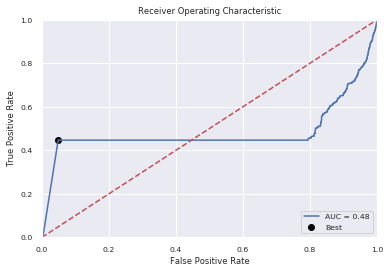

0.9969806841780277
Best Threshold=0.996981, G-Mean=0.890


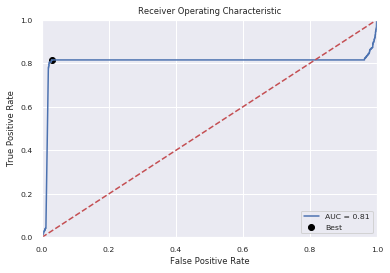

0.9949624615956724
Best Threshold=0.994742, G-Mean=0.198


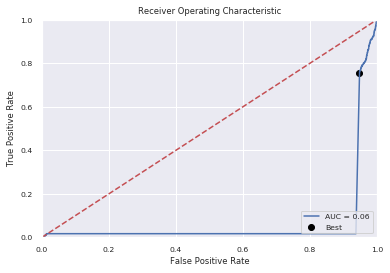

0.9961440166213247
Best Threshold=0.996144, G-Mean=0.967


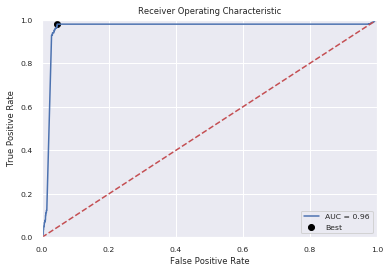

0.9975192888607739
Best Threshold=0.997519, G-Mean=0.351


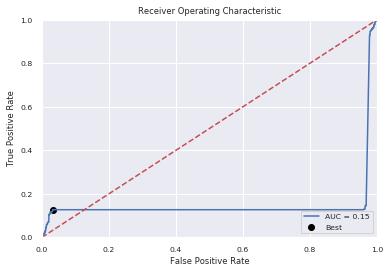

0.9959296244353243
Best Threshold=0.995930, G-Mean=0.239


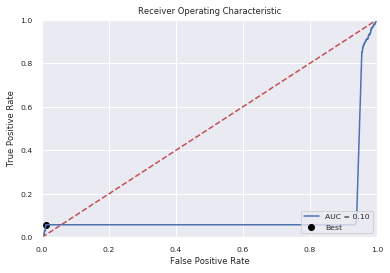

0.9953418345642874
Best Threshold=0.995342, G-Mean=0.956


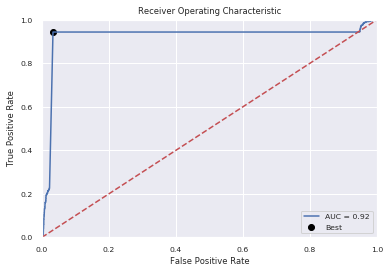

0.9967761374893149
Best Threshold=0.996776, G-Mean=0.231


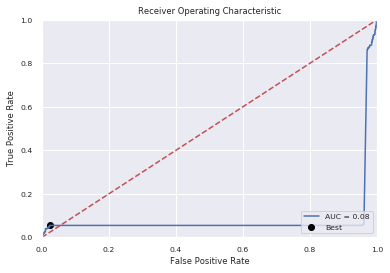

0.9966109435749622
Best Threshold=0.996611, G-Mean=0.928


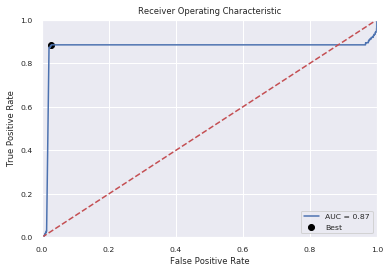

1.9977454914131063
Best Threshold=0.894523, G-Mean=0.175


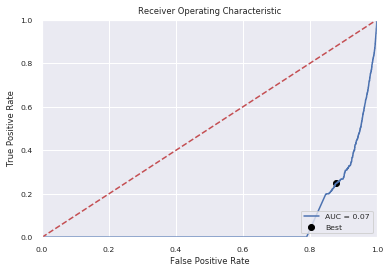

0.9961509093243952
Best Threshold=0.995105, G-Mean=0.225


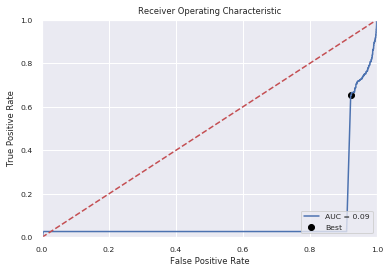

0.9964968553375546
Best Threshold=0.996497, G-Mean=0.869


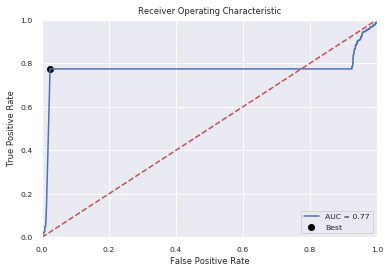

0.9965446037689178
Best Threshold=0.996131, G-Mean=0.233


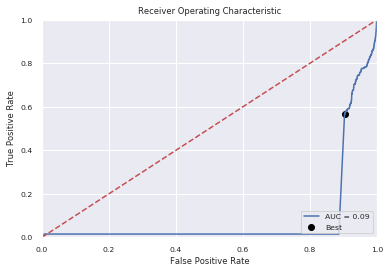

0.9987589848019817
Best Threshold=0.983271, G-Mean=0.219


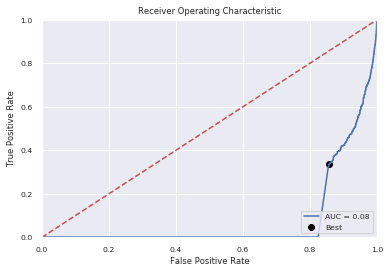

0.9934359633914319
Best Threshold=0.993436, G-Mean=0.691


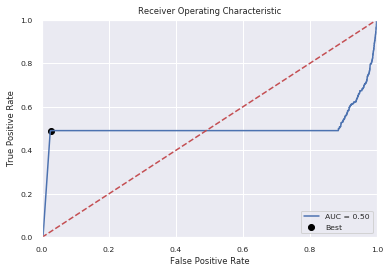

0.99362657077809
Best Threshold=0.992730, G-Mean=0.761


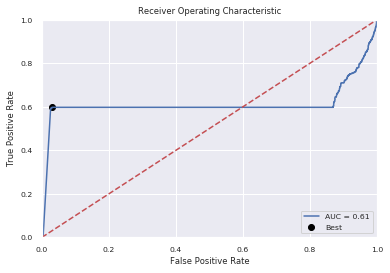

0.997539164798367
Best Threshold=0.995922, G-Mean=0.926


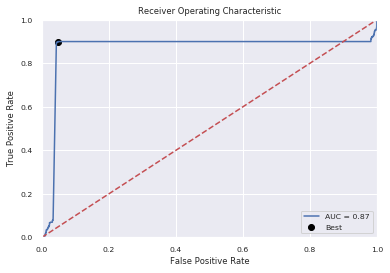

0.9952255496972058
Best Threshold=0.995226, G-Mean=0.866


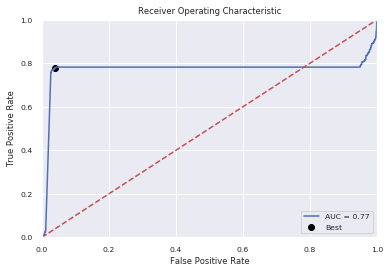

0.994426935607097
Best Threshold=0.994427, G-Mean=0.723


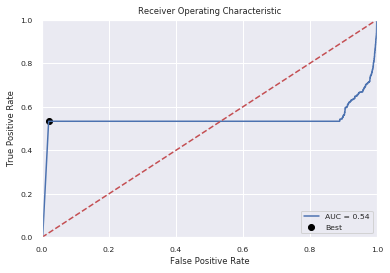

0.9971711106009179
Best Threshold=0.996829, G-Mean=0.880


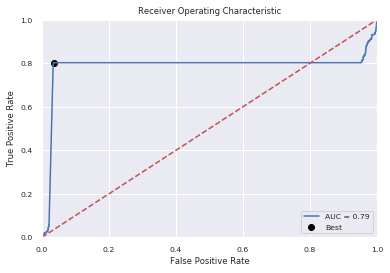

0.995242378240448
Best Threshold=0.931506, G-Mean=0.234


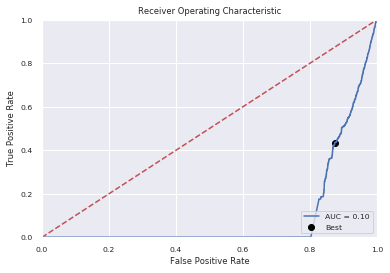

0.9970233254743794
Best Threshold=0.997023, G-Mean=0.796


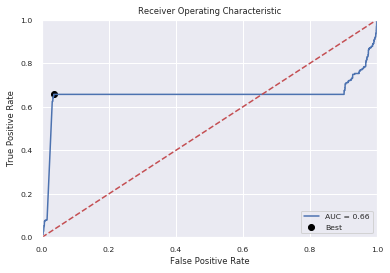

0.9902994613370144
Best Threshold=0.990299, G-Mean=0.687


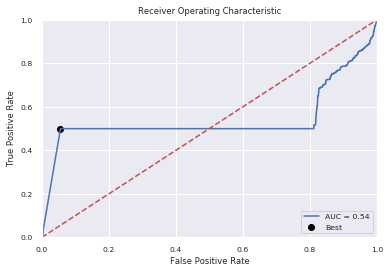

0.9956287754492031
Best Threshold=0.995629, G-Mean=0.328


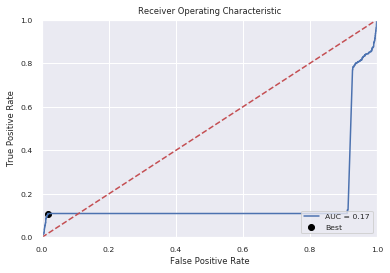

0.9954694857978845
Best Threshold=0.995469, G-Mean=0.342


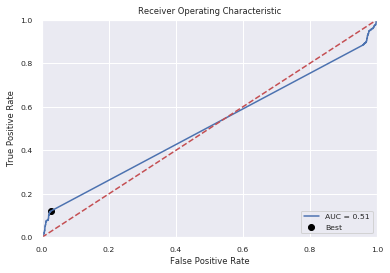

0.9977478461426847
Best Threshold=0.997748, G-Mean=0.115


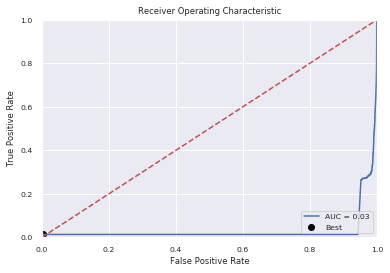

0.9981643560511577
Best Threshold=0.998164, G-Mean=0.961


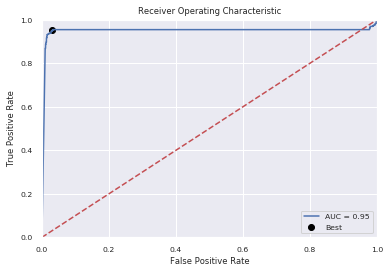

0.9963024526785698
Best Threshold=0.996302, G-Mean=0.913


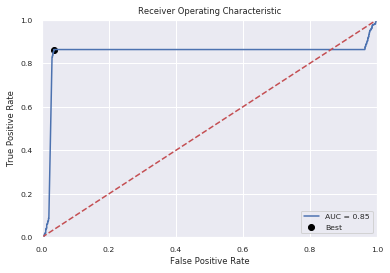

0.9973548427349
Best Threshold=0.976077, G-Mean=0.229


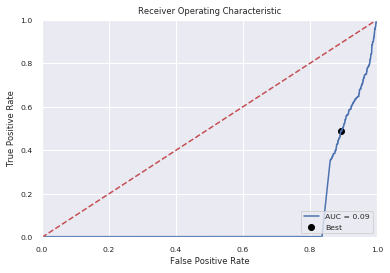

0.9933364392646995
Best Threshold=0.993336, G-Mean=0.818


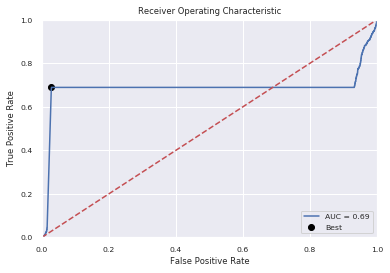

0.9969703724000089
Best Threshold=0.996970, G-Mean=0.952


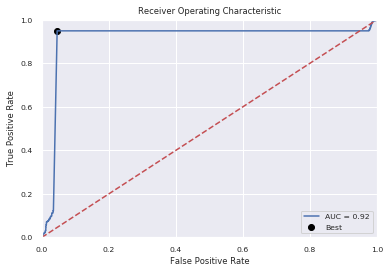

0.996538704374466
Best Threshold=0.996539, G-Mean=0.917


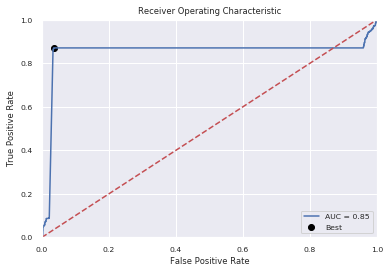

0.9961254721868935
Best Threshold=0.996125, G-Mean=0.246


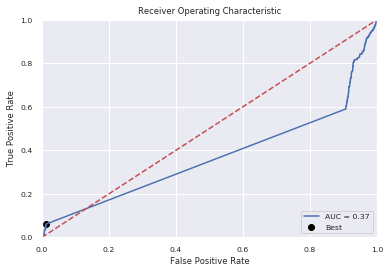

0.9979117658851735
Best Threshold=0.997912, G-Mean=0.971


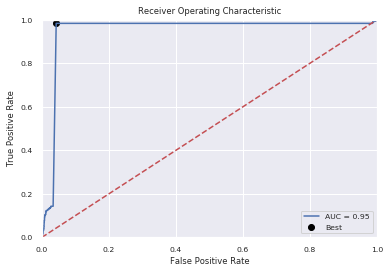

0.9965445774002495
Best Threshold=0.996545, G-Mean=0.952


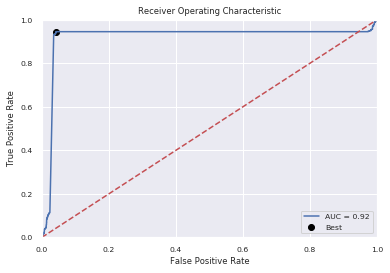

0.996614924962863
Best Threshold=0.991081, G-Mean=0.208


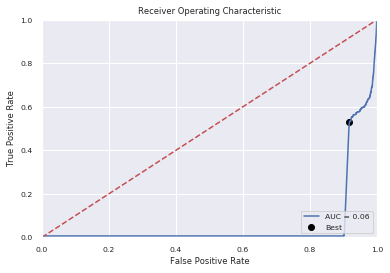

0.9932936930844024
Best Threshold=0.993294, G-Mean=0.821


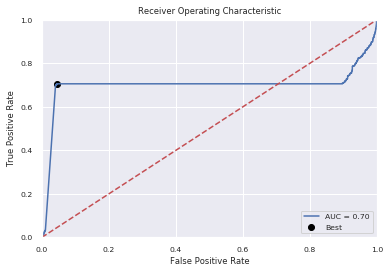

0.9971830494178028
Best Threshold=0.997183, G-Mean=0.975


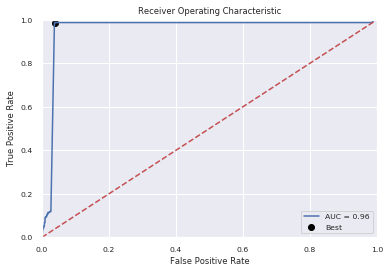

0.9960038518891714
Best Threshold=0.996004, G-Mean=0.289


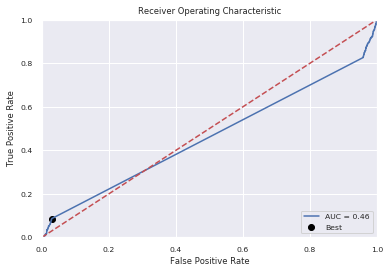

0.9945553310859563
Best Threshold=0.994555, G-Mean=0.825


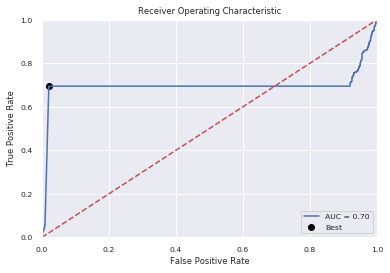

0.9953688562821252
Best Threshold=0.995369, G-Mean=0.867


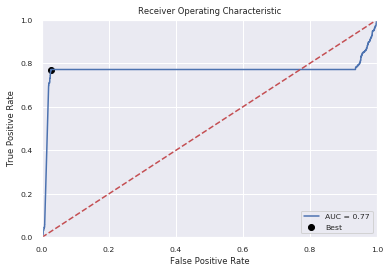

0.9942772522326259
Best Threshold=0.994277, G-Mean=0.933


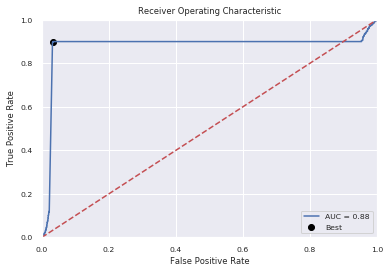

0.9968033110622984
Best Threshold=0.996803, G-Mean=0.288


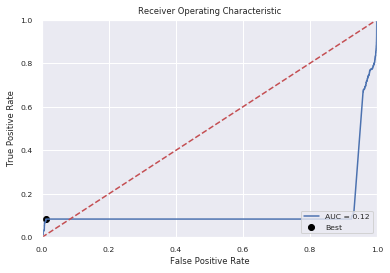

0.9953678005316399
Best Threshold=0.995368, G-Mean=0.932


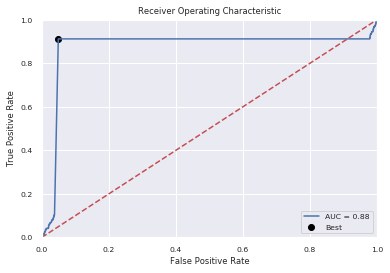

0.99777639081488
Best Threshold=0.997776, G-Mean=0.271


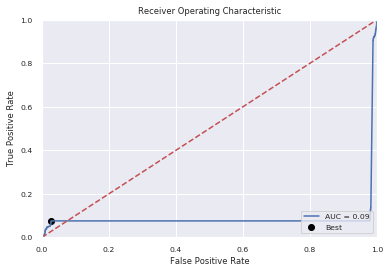

0.9958556116386528
Best Threshold=0.995856, G-Mean=0.217


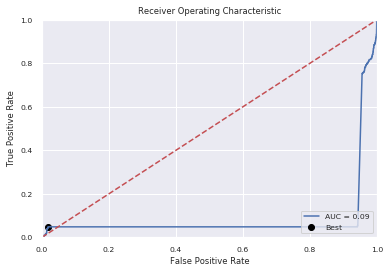

In [65]:
thresh_lgbm = []
roc_lgbm = []
for i in range(50):    
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    #probs = model.predict_proba(X_test)
    #preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lgbm_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print(optimal_threshold)
    thresh_lgbm.append(optimal_threshold)
    roc_lgbm.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [66]:
sum(roc_lgbm)/50

0.5319714506151454

In [67]:
for i in range(50):
    prediction_lgbm_test_p[:,i] = to_labels(prediction_lgbm_test_p[:,i],thresh_lgbm[i])

In [68]:
multilabel_confusion_matrix(Y_test.numpy(), prediction_lgbm_test_p)

array([[[102010,   4094],
        [   163,    750]],

       [[102606,   3689],
        [   109,    613]],

       [[105426,    772],
        [   791,     28]],

       [[102633,   3949],
        [     4,    431]],

       [[ 99420,   5050],
        [  1409,   1138]],

       [[103425,   3082],
        [    94,    416]],

       [[104572,   1484],
        [   945,     16]],

       [[101556,   4853],
        [    12,    596]],

       [[103162,   3398],
        [   399,     58]],

       [[104333,   1297],
        [  1307,     80]],

       [[102771,   3478],
        [    43,    725]],

       [[104126,   2470],
        [   398,     23]],

       [[103650,   2958],
        [    47,    362]],

       [[ 99699,      0],
        [  7318,      0]],

       [[105882,    420],
        [   696,     19]],

       [[103624,   2564],
        [   187,    642]],

       [[105446,    630],
        [   927,     14]],

       [[103625,     45],
        [  3344,      3]],

       [[102546,   2706],
  

In [69]:
scores_lgbm = []
for i in range(50):
    scores_lgbm.append(binary_classification_performance(Y_test[:,i].numpy(),prediction_lgbm_test_p[:,i]))

/home/skarra7/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/skarra7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/home/skarra7/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  


In [70]:
f_lgbm = pd.concat(scores_lgbm)

In [71]:
f_lgbm.mean(axis=0)

Accuracy                           0.966600
Precision (or PPV)                 0.103000
Recall (senitivity or TPR)         0.498600
f1 score                           0.158163
Specificty (or TNR)                0.105102
NPV                                0.498600
True Positive                 103066.560000
True Negative                    395.380000
False Positive                  2796.720000
False Negative                   758.340000
dtype: float64

# Exhaustive search for Optimization

In [72]:
x = pd.DataFrame(X_recommend_t)
x.sum(axis=1).value_counts()
x['Total'] = x.sum(axis=1)

In [73]:
y=x[x['Total'] >= 6]

In [74]:
infinity = pd.DataFrame(X_freq_1_test)
histo = pd.DataFrame(X_recent_2_test)

In [75]:
inf_new=infinity.loc[y.index,:]
hist_new=histo.loc[y.index,:]


In [76]:

def dfs(x,start,end,cnt,l_):
    if start==end:
        return []
    if cnt==5:
        ans.append(l_)
        return 
    
    for i in range(start,end):
        if int(x[i])==1:           
            dfs(x,i+1,end,cnt+1,l_+[i])
                    
d={}
cnt={}
v={}
for i in y.index:
    p=y.loc[i,:]
    l=list(p)
    ans=[]
    dfs(l,0,len(l),0,[])

    v[i]=ans
    for m in range(len(ans)):
        n=[0]*50
        for k in range(len(ans[m])):
            n[ans[m][k]]=1
        if i not in d:
            d[i]=[]
        d[i].append(n)


In [77]:
global_l=[]    
for i in d:
    for x in d[i]:
        global_l.append([i]+x)
        

In [78]:
global_df=pd.DataFrame(global_l,columns=['User']+[i for i in range(50)]).set_index('User')

In [79]:
opt_freq =inf_new.loc[global_df.index]

In [80]:
opt_hist = hist_new.loc[global_df.index]

In [81]:
opt_rec = global_df

In [82]:
print(opt_freq.shape)
print(opt_hist.shape)
print(opt_rec.shape)

(505809, 50)
(505809, 200)
(505809, 50)


In [83]:
opt_freq_T = torch.FloatTensor(opt_freq.values)
opt_hist_T = torch.FloatTensor(opt_hist.values.reshape(-1,50,4))
opt_rec_T = torch.FloatTensor(opt_rec.values)
opt_indicator_T = torch.ones([505809, 50])

In [84]:
print(opt_freq_T.shape)
print(opt_hist_T.shape)
print(opt_rec_T.shape)
print(opt_indicator_T.shape)

torch.Size([505809, 50])
torch.Size([505809, 50, 4])
torch.Size([505809, 50])
torch.Size([505809, 50])


In [85]:
test_dataset = TensorDataset(opt_freq_T, opt_hist_T, opt_rec_T, opt_rec_T)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [86]:
probas_opt = []
for step_num, batch_data in enumerate(test_dataloader):
        freq, recent, recommend, indicator = tuple(t.to(device)for t in batch_data)
        logits_opt = model(freq, recent, recommend, indicator)
        numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
        numpy_probas_opt = sigmoid_v(numpy_logits_opt)
        probas_opt.append(pd.DataFrame(numpy_probas_opt).round(decimals=6))


#logits_opt = model(opt_freq_T.to(device), opt_hist_T.to(device), opt_rec_T.to(device), opt_indicator_T.to(device)).to('cpu')
#numpy_logits_opt = logits_opt.detach().numpy()
#numpy_probas_opt = sigmoid_v(numpy_logits_opt)

torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32, 50, 20])
torch.Size([32, 50, 45])
torch.Size([32, 50, 4])
torch.Size([32

In [87]:
fins = pd.concat(probas_opt)

In [88]:
fins = fins*opt_rec.values

In [89]:
scor = pd.DataFrame()
#fins.sum(axis = 1)
scor['total'] = fins.sum(axis = 1)
#fins.values.round(9)
scor['index'] = global_df.index

In [90]:
scor.index = global_df.index

In [91]:
opt_rec_T_F = global_df

In [92]:
opt_rec_T_F['prob'] = scor['total']
opt_rec_T_F['ind'] = scor['index']

In [93]:
lp = opt_rec_T_F.sort_values('prob', ascending=False).drop_duplicates(['ind'])

In [94]:
mp= lp.reindex(y.index)

In [95]:
mp['prob'].sum()

1314.26753

In [96]:
del lp['prob']
del lp['ind']

In [97]:
mp

0  1  2  3  4  5  6  7  8  9  ...  42  43  44  45  46  47  48  49  \
35      0  0  0  0  0  0  0  0  0  0  ...   0   0   0   1   0   0   0   0   
146     0  0  0  0  1  0  1  0  0  0  ...   0   0   0   0   0   0   0   0   
169     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
174     0  0  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
227     0  1  0  0  0  0  0  0  0  1  ...   0   0   0   0   1   0   0   0   
...    .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
106827  0  0  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   1   0   
106829  1  0  0  0  1  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
106833  0  0  0  0  1  0  0  0  0  0  ...   0   0   0   1   0   0   0   0   
106945  0  0  0  0  0  0  0  0  0  0  ...   1   0   0   0   0   0   0   0   
106950  0  0  0  0  0  0  0  0  0  0  ...   0   1   0   0   1   0   0   0   

            prob     ind  
35      0.018140      35  
146     0.342458     146  
169     0.018777     169  
174     0.014745     174  
227     0.020527     227  
...          ...     ...  
106827  0.014973  106827  
106829  0.019062  106829  
106833  0.327250  106833  
106945  0.014024  106945  
106950  0.014989  106950  

[3531 rows x 52 columns]

In [98]:
lr_p = pd.DataFrame(prediction_lgbm_test_p)

In [99]:
lr_p

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0   
1       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2       0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
107012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
107013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
107014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
107015  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
107016  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

         43   44   45   46   47   48   49  
0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1       0.0  0.0  1.0  0.0  0.0  0.0  0.0  
2       0.0  0.0  0.0  0.0  0.0  0.0  1.0  
3       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
107012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
107013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
107014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
107015  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
107016  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[107017 rows x 50 columns]

In [100]:
lr_ding = lr_p.loc[y.index]

In [101]:
del y['Total']

In [102]:
p=lr_ding*y.values

In [103]:
p

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
35      0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
146     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
169     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
174     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0   
227     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
106827  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
106829  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
106833  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
106945  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
106950  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

         43   44   45   46   47   48   49  
35      0.0  0.0  1.0  0.0  0.0  0.0  0.0  
146     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
169     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
174     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
227     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  
106827  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
106829  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
106833  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
106945  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
106950  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3531 rows x 50 columns]

In [104]:
s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)

In [105]:
for ind in p.index:
    s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
    

In [106]:
s_=s.reset_index()

In [107]:
opt_rec_=opt_rec.reset_index().rename(columns={'User':'index'})

In [108]:
#col=opt_rec.columns
final=pd.merge(s_,opt_rec_,on=list(s_.columns),how='left').reset_index(drop=True).set_index('index')

In [109]:
final['prob'].mean()

0.0660703755158184